In [54]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import random
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_standardized_filter.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_all_sso_filter.parquet')

# data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
# datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

impl_volatility = 'impl_volatility_h_1_step'
target = 'impl_volatility_h_1_step'

# data_sso = pd.read_parquet('//Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_scaled_sso.parquet')
# datat_sso = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_sso.parquet')

# Filter data to ensure 'prc_option' is below a certain number, e.g., 0.5
# prc_filter = 0.125

# data = data[data['prc_option'] > prc_filter]
# datat = datat[datat['prc_option'] > prc_filter]
# data_sso = data_sso[data_sso['prc_option'] > prc_filter]
# datat_sso = datat_sso[datat_sso['prc_option'] > prc_filter]


test_data = datat[datat['date'] >= '2021-01-01']
# total_train = data[data['date'] < '2021-01-01']

basic = ['moneyness', 'T', 'moneyness_squared', 'tau_squared', 'moneyness_tau']
macro_features = ['1Y_bond','2Y_bond','FF_rate', 'gold_price','reces_indi','10Y_RIR', 'CLOSE_vix', 'hi-lo_vix']
tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', '5_day_rolling_return_stock', 'hi-lo_stock', ]
option_specific = ['spread_option', 'volume', 'prc_option', 'previous_iv', 'previous_iv_all']

totalList_ahbs = basic
totalList = ['moneyness', 'T'] + macro_features + tickers + stock_specific + option_specific
# totalList_nn = basic + ['previous_iv',
#  'spread_option',
#  '2Y_bond',
#  'RET',
#  'cp_flag',
#  'ticker_TSLA',
#  'ticker_AMZN']
totalList_nn = basic + ['previous_iv', 'cp_flag', 'ticker_TSLA', 'ticker_AMZN']
# totalList_xgb = ['T', 'moneyness', 'previous_iv', 'cp_flag', 'ticker_TSLA']
totalList_xgb = basic + ['previous_iv', 'cp_flag', 'ticker_TSLA', 'ticker_AMZN']

In [27]:
totalList_nn

['moneyness',
 'T',
 'moneyness_squared',
 'tau_squared',
 'moneyness_tau',
 'previous_iv',
 'cp_flag',
 'ticker_TSLA',
 'ticker_AMZN']

In [78]:
totalList

['moneyness',
 'T',
 '1Y_bond',
 '2Y_bond',
 'FF_rate',
 'gold_price',
 'reces_indi',
 '10Y_RIR',
 'CLOSE_vix',
 'hi-lo_vix',
 'ticker_AAPL',
 'ticker_AMZN',
 'ticker_META',
 'ticker_MSFT',
 'ticker_NVDA',
 'ticker_TSLA',
 'BID',
 'ASK',
 'daily_return_indicator_stock',
 '5_day_rolling_return_stock',
 'hi-lo_stock',
 'spread_option',
 'volume',
 'prc_option',
 'previous_iv',
 'previous_iv_all']

In [55]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to compute Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

# Function to compute Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

# Two-step approach with Newey-West error calculation
def two_step_model_with_newey_west(train_data, test_data, adhbs_features, nn_features, target, output_csv_path):
    """
    Execute the two-step modeling process (ADHBS + NN) with Newey-West standard error computation.
    Parameters:
    - train_data: Training dataset
    - test_data: Testing dataset
    - adhbs_features: Features for the ADHBS model
    - nn_features: Features for the Neural Network
    - target: Target variable name
    - output_csv_path: Path to save the results CSV
    """
    # Step 1: ADHBS Model
    print("Step 1: Training ADHBS model...")
    y_train = train_data[target]
    X_train_adhbs = sm.add_constant(train_data[adhbs_features])
    adhbs_model = sm.OLS(y_train, X_train_adhbs).fit()

    train_data['ADHBS_Predictions'] = adhbs_model.predict(X_train_adhbs)
    train_data['Errors'] = train_data[target] - train_data['ADHBS_Predictions']

    # Step 1.1: ADHBS Predictions for test data
    X_test_adhbs = sm.add_constant(test_data[adhbs_features])
    test_data['ADHBS_Predictions'] = adhbs_model.predict(X_test_adhbs)
    test_data['Errors'] = test_data[target] - test_data['ADHBS_Predictions']

    # Step 2: Neural Network to correct errors
    print("Step 2: Training Neural Network on ADHBS errors...")
    nn_model = create_nn_model(input_dim=len(nn_features))
    nn_model.fit(train_data[nn_features].values, train_data['Errors'].values, epochs=50, batch_size=32, verbose=1)

    test_data['NN_Corrections'] = nn_model.predict(test_data[nn_features].values).flatten()
    test_data['Final_Predictions'] = test_data['ADHBS_Predictions'] + test_data['NN_Corrections']

    # Compute performance metrics
    rmse = np.sqrt(mean_squared_error(test_data[target], test_data['Final_Predictions']))
    r2 = r2_score(test_data[target], test_data['Final_Predictions'])
    print(f"Two-step model - RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Compute Newey-West standard error
    test_data['Prediction_Errors'] = test_data[target] - test_data['Final_Predictions']
    daily_avg_errors = test_data.groupby('date')['Prediction_Errors'].mean()
    nw_std_error = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error}")

    # Save the results to a CSV
    result_df = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error] * len(daily_avg_errors)
    })
    result_df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

    return test_data, nw_std_error

# # Step 1: ADHBS Model
def adhbs_model(data, features, target, title):
    y = data[target]
    X = sm.add_constant(data[features])  # Add constant for intercept
    model = sm.OLS(y, X).fit()

    # Predictions and error calculations
    data['Predictions'] = model.predict(X)
    data['Errors'] = y - data['Predictions']

    # Metrics
    rmse = np.sqrt(mean_squared_error(y, data['Predictions']))
    r2 = r2_score(y, data['Predictions'])
    print(f"{title} RMSE: {rmse}, R²: {r2}")

    # Feature importance
    coefs = model.params.abs()
    importance = coefs / coefs.sum()
    top_features = importance.sort_values(ascending=False).head(10)

    return model, data['Errors']

# Step 2: Neural Network to Correct Errors
def create_nn_model(input_dim, neurons=32, layers=1, dropout_rate=0):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    for layer in range(layers):
        model.add(tf.keras.layers.Dense(max(1, neurons // (2 ** layer)), activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error', metrics=['mse'])
    return model

def train_nn(data, features, target, epochs=50, batch_size=32):

    X = data[features].values  # Use features directly without additional scaling
    y = data[target].values  # Target values

    # Create and train the neural network
    model = create_nn_model(X.shape[1], neurons=32, layers=1, dropout_rate=0.05)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)

    # Make predictions and evaluate performance
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)

    print(f"NN Model RMSE: {rmse}, R²: {r2}")
    return model


# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

def two_step_model_oos(train_data, test_data, totalList_ahbs, nn_features, target):
    """
    Execute the two-step modeling process (ADHBS + NN) for out-of-sample predictions.
    
    Parameters:
    - train_data: Training dataset (in-sample data).
    - test_data: Testing dataset (out-of-sample data).
    - adhbs_features: Features for the ADHBS model.
    - nn_features: Features for the Neural Network.
    - target: Target column name (implied volatility in this case).
    
    Returns:
    - Final OOS predictions.
    """
    print("Step 1: Running ADHBS Model on Training Data...")
    adhbs_model_trained, train_errors = adhbs_model(train_data, totalList_ahbs, target, "ADHBS Model (Train)")

    # Predict on the test data using the trained ADHBS model
    print("Step 1.1: Generating ADHBS Predictions for Test Data...")
    X_test = sm.add_constant(test_data[totalList_ahbs])
    test_data['ADHBS_Predictions'] = adhbs_model_trained.predict(X_test)

    # Calculate residuals for the test data
    test_data['Errors'] = test_data[target] - test_data['ADHBS_Predictions']

    print("Step 2: Training Neural Network on Training Data Errors...")
    train_data['Errors'] = train_errors
    nn_model = train_nn(train_data, nn_features, 'Errors')  # Train NN on training data errors

    print("Step 2.1: Generating NN Corrections for Test Data...")
    X_nn_test = test_data[nn_features].values
    test_data['NN_Corrections'] = nn_model.predict(X_nn_test).flatten()

    # Combine ADHBS predictions and NN corrections for final OOS predictions
    test_data['Final_Predictions'] = test_data['ADHBS_Predictions'] + test_data['NN_Corrections']

    # Evaluate performance on the out-of-sample data
    rmse_oos = np.sqrt(mean_squared_error(test_data[target], test_data['Final_Predictions']))
    r2_oos = r2_score(test_data[target], test_data['Final_Predictions'])

    print(f"Out-of-Sample RMSE: {rmse_oos:.4f}")
    print(f"Out-of-Sample R²: {r2_oos:.4f}")

    return test_data[['date', 'Ticker', target, 'Final_Predictions', 'ADHBS_Predictions', 'NN_Corrections', 'Errors']], nn_model

output_csv_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/ahbs_nn.csv'

# oos_results, final_nn_model = two_step_model_oos(data, datat, totalList_ahbs, totalList_nn, 'impl_volatility')


test_results, nw_error = two_step_model_with_newey_west(data, datat, totalList_ahbs, totalList_nn, impl_volatility, output_csv_path)


Step 1: Training ADHBS model...
Step 2: Training Neural Network on ADHBS errors...
Epoch 1/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step - loss: 0.0520 - mse: 0.0520
Epoch 2/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step - loss: 0.0320 - mse: 0.0320
Epoch 3/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 281us/step - loss: 0.0301 - mse: 0.0301
Epoch 4/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step - loss: 0.0294 - mse: 0.0294
Epoch 5/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step - loss: 0.0291 - mse: 0.0291
Epoch 6/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - loss: 0.0289 - mse: 0.0289
Epoch 7/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step - loss: 0.0287 - mse: 0.0287
Epoch 8/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 281us/step - loss: 0.0286 - mse: 0.0286
Epoch 9/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step - loss: 0.0286 - mse: 0.0286
Epoch 10/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step - loss: 0.0285 - mse: 0.0285
Epoch 11/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 273us/step - loss: 0

In [40]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Function to compute Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

# Step 1: ADHBS Model
def adhbs_model(data, features, target, title):
    """
    Fit an ADHBS model and return the predictions and errors.
    """
    y = data[target]
    X = sm.add_constant(data[features])  # Add constant for intercept
    model = sm.OLS(y, X).fit()

    # Predictions and error calculations
    data['ADHBS_Predictions'] = model.predict(X)
    data['Errors'] = y - data['ADHBS_Predictions']

    # Metrics
    rmse = np.sqrt(mean_squared_error(y, data['ADHBS_Predictions']))
    r2 = r2_score(y, data['ADHBS_Predictions'])
    print(f"{title} RMSE: {rmse}, R²: {r2}")

    return model, data['Errors']

# Step 2: Train XGBoost model to correct errors
def train_xgboost(data, features, target, n_estimators=50, max_depth=5, learning_rate=0.1, subsample=1):
    """
    Train an XGBoost model to predict errors.
    """
    X = data[features].values
    y = data[target].values

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42,
        objective='reg:squarederror'
    )
    model.fit(X, y)

    # Make predictions and evaluate performance
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)

    print(f"XGBoost Model RMSE: {rmse}, R²: {r2}")
    return model

# Two-step approach with Newey-West standard error
def two_step_model_with_newey_west(train_data, test_data, adhbs_features, xgb_features, target, output_csv_path):
    """
    Execute the two-step modeling process (ADHBS + XGBoost) with Newey-West error calculation.
    """
    # Step 1: ADHBS Model
    print("Step 1: Training ADHBS model...")
    adhbs_model_trained, train_errors = adhbs_model(train_data, adhbs_features, target, "ADHBS Model (Train)")

    # Predict on the test data using the trained ADHBS model
    print("Step 1.1: Generating ADHBS Predictions for Test Data...")
    X_test_adhbs = sm.add_constant(test_data[adhbs_features])
    test_data['ADHBS_Predictions'] = adhbs_model_trained.predict(X_test_adhbs)
    test_data['Errors'] = test_data[target] - test_data['ADHBS_Predictions']

    # Step 2: Train XGBoost on ADHBS residuals
    print("Step 2: Training XGBoost on ADHBS Errors...")
    train_data['Errors'] = train_errors
    xgb_model = train_xgboost(train_data, xgb_features, 'Errors')

    # Generate corrections for test data
    print("Step 2.1: Generating XGBoost Corrections for Test Data...")
    X_test_xgb = test_data[xgb_features].values
    test_data['XGB_Corrections'] = xgb_model.predict(X_test_xgb).flatten()

    # Combine ADHBS predictions and XGBoost corrections
    test_data['Final_Predictions'] = test_data['ADHBS_Predictions'] + test_data['XGB_Corrections']

    # Evaluate performance
    rmse_oos = np.sqrt(mean_squared_error(test_data[target], test_data['Final_Predictions']))
    r2_oos = r2_score(test_data[target], test_data['Final_Predictions'])
    print(f"Out-of-Sample RMSE: {rmse_oos:.4f}")
    print(f"Out-of-Sample R²: {r2_oos:.4f}")

    # Compute Newey-West standard error
    test_data['Prediction_Errors'] = test_data[target] - test_data['Final_Predictions']
    daily_avg_errors = test_data.groupby('date')['Prediction_Errors'].mean()
    nw_std_error = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error}")

    # Save the results to a CSV
    result_df = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error] * len(daily_avg_errors)
    })
    result_df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

    return test_data, nw_std_error

# Example usage
target = impl_volatility  # Target variable
output_csv_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/ahbs_xgb.csv'

test_results, nw_error = two_step_model_with_newey_west(data, datat, totalList_ahbs, totalList_xgb, target, output_csv_path)




Step 1: Training ADHBS model...
ADHBS Model (Train) RMSE: 0.31230109153281654, R²: 0.46675377295588727
Step 1.1: Generating ADHBS Predictions for Test Data...
Step 2: Training XGBoost on ADHBS Errors...
XGBoost Model RMSE: 0.15895866851811344, R²: 0.740927432945091
Step 2.1: Generating XGBoost Corrections for Test Data...
Out-of-Sample RMSE: 0.1359
Out-of-Sample R²: 0.8541
Newey-West Standard Error (Based on Daily Averages): 0.004442138917918024
Results saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/ahbs_xgb.csv


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# Step 2: Train Random Forest model to correct errors
def train_random_forest(data, features, target, n_estimators=50, max_depth=5, max_features=None, min_samples_split=2, random_state=42):
    """
    Train a Random Forest model to predict errors.
    """
    X = data[features].values
    y = data[target].values

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        random_state=random_state
    )
    model.fit(X, y)

    # Make predictions and evaluate performance
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)

    print(f"Random Forest Model RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return model

# Two-step approach with Newey-West standard error
def two_step_model_with_newey_west_rf(train_data, test_data, adhbs_features, rf_features, target, output_csv_path):
    """
    Execute the two-step modeling process (ADHBS + Random Forest) with Newey-West error calculation.
    """
    # Step 1: ADHBS Model
    print("Step 1: Training ADHBS model...")
    adhbs_model_trained, train_errors = adhbs_model(train_data, adhbs_features, target, "ADHBS Model (Train)")

    # Predict on the test data using the trained ADHBS model
    print("Step 1.1: Generating ADHBS Predictions for Test Data...")
    X_test_adhbs = sm.add_constant(test_data[adhbs_features])
    test_data['ADHBS_Predictions'] = adhbs_model_trained.predict(X_test_adhbs)
    test_data['Errors'] = test_data[target] - test_data['ADHBS_Predictions']

    # Step 2: Train Random Forest on ADHBS residuals
    print("Step 2: Training Random Forest on ADHBS Errors...")
    train_data['Errors'] = train_errors
    rf_model = train_random_forest(train_data, rf_features, 'Errors', n_estimators, max_depth, max_features)

    # Generate corrections for test data
    print("Step 2.1: Generating Random Forest Corrections for Test Data...")
    X_test_rf = test_data[rf_features].values
    test_data['RF_Corrections'] = rf_model.predict(X_test_rf).flatten()

    # Combine ADHBS predictions and Random Forest corrections
    test_data['Final_Predictions'] = test_data['ADHBS_Predictions'] + test_data['RF_Corrections']

    # Evaluate performance
    rmse_oos = np.sqrt(mean_squared_error(test_data[target], test_data['Final_Predictions']))
    r2_oos = r2_score(test_data[target], test_data['Final_Predictions'])
    print(f"Out-of-Sample RMSE: {rmse_oos:.4f}")
    print(f"Out-of-Sample R²: {r2_oos:.4f}")

    # Compute Newey-West standard error
    test_data['Prediction_Errors'] = test_data[target] - test_data['Final_Predictions']
    daily_avg_errors = test_data.groupby('date')['Prediction_Errors'].mean()
    nw_std_error = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error:.4f}")

    # Save the results to a CSV
    result_df = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error] * len(daily_avg_errors)
    })
    result_df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

    return test_data, nw_std_error

# Define hyperparameters for Random Forest
n_estimators = 100  # Optimal value based on tuning
max_depth = 10      # Optimal value based on tuning
max_features = 5    # Optimal value based on tuning
min_samples_split = 2  # Optimal value based on tuning

# Example usage
target = impl_volatility  # Target variable
output_csv_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/ahbs_rf.csv'

# Run the two-step model process with Random Forest
test_results, nw_error = two_step_model_with_newey_west_rf(data, datat, totalList_ahbs, totalList_xgb, target, output_csv_path)


Step 1: Training ADHBS model...
ADHBS Model (Train) RMSE: 0.31230109153281654, R²: 0.46675377295588727
Step 1.1: Generating ADHBS Predictions for Test Data...
Step 2: Training Random Forest on ADHBS Errors...
Random Forest Model RMSE: 0.1388, R²: 0.8024
Step 2.1: Generating Random Forest Corrections for Test Data...
Out-of-Sample RMSE: 0.1354
Out-of-Sample R²: 0.8552
Newey-West Standard Error (Based on Daily Averages): 0.0043
Results saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/ahbs_rf.csv


Step 1: Running ADHBS Model on Training Data...
ADHBS Model (Train) RMSE: 0.2877890099145444, R²: 0.4491437787290212


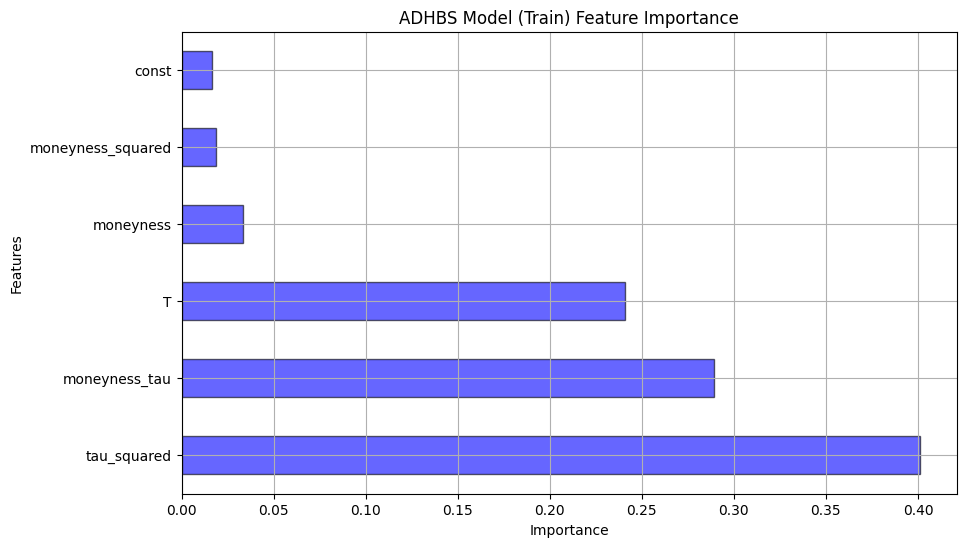

Step 1.1: Generating ADHBS Predictions for Test Data...
Step 2: Training Neural Network on Training Data Errors...
XGBoost Model RMSE: 0.12376223604556358, R²: 0.8150612642728172
Step 2.1: Generating NN Corrections for Test Data...
Out-of-Sample RMSE: 0.1093
Out-of-Sample R²: 0.8740


In [37]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Function to compute Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

# Step 1: ADHBS Model
def adhbs_model(data, features, target, title):
    y = data[target]
    X = sm.add_constant(data[features])  # Add constant for intercept
    model = sm.OLS(y, X).fit()

    # Predictions and error calculations
    data['Predictions'] = model.predict(X)
    data['Errors'] = y - data['Predictions']

    # Metrics
    rmse = np.sqrt(mean_squared_error(y, data['Predictions']))
    r2 = r2_score(y, data['Predictions'])
    print(f"{title} RMSE: {rmse}, R²: {r2}")

    # Feature importance
    coefs = model.params.abs()
    importance = coefs / coefs.sum()
    top_features = importance.sort_values(ascending=False).head(10)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features.plot(kind='barh', color='blue', alpha=0.6, edgecolor='black')
    plt.title(f"{title} Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.grid(True)
    plt.show()

    return model, data['Errors']

def train_xgboost(data, features, target, n_estimators=175, max_depth=3, learning_rate=0.1, subsample=1, random_state=42):
    """
    Train an XGBoost model to predict target values (errors in this case).
    
    Parameters:
    - data: DataFrame containing the features and target.
    - features: List of feature columns.
    - target: Target column name (errors in this case).
    - n_estimators: Number of boosting rounds.
    - max_depth: Maximum tree depth for base learners.
    - learning_rate: Learning rate (eta).
    - subsample: Subsample ratio of the training instances.
    - random_state: Random seed for reproducibility.
    
    Returns:
    - Trained XGBoost model.
    """
    X = data[features].values
    y = data[target].values

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=random_state,
        objective='reg:squarederror'
    )
    model.fit(X, y)

    # Make predictions and evaluate performance
    predictions = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)

    print(f"XGBoost Model RMSE: {rmse}, R²: {r2}")
    return model

# Hyperparameters for XGBoost
# n_estimators = 175
# max_depth = 5
# learning_rate = 0.1
# subsample = 1


def two_step_model_oos(train_data, test_data, totalList_ahbs, totalList_xgb, target):
    """
    Execute the two-step modeling process (ADHBS + NN) for out-of-sample predictions.
    
    Parameters:
    - train_data: Training dataset (in-sample data).
    - test_data: Testing dataset (out-of-sample data).
    - adhbs_features: Features for the ADHBS model.
    - nn_features: Features for the Neural Network.
    - target: Target column name (implied volatility in this case).
    
    Returns:
    - Final OOS predictions.
    """
    print("Step 1: Running ADHBS Model on Training Data...")
    adhbs_model_trained, train_errors = adhbs_model(train_data, totalList_ahbs, target, "ADHBS Model (Train)")

    # Predict on the test data using the trained ADHBS model
    print("Step 1.1: Generating ADHBS Predictions for Test Data...")
    X_test = sm.add_constant(test_data[totalList_ahbs])
    test_data['ADHBS_Predictions'] = adhbs_model_trained.predict(X_test)

    # Calculate residuals for the test data
    test_data['Errors'] = test_data[target] - test_data['ADHBS_Predictions']

    print("Step 2: Training Neural Network on Training Data Errors...")
    train_data['Errors'] = train_errors
    xgb_model = train_xgboost(train_data, totalList_xgb, 'Errors')  # Train NN on training data errors

    print("Step 2.1: Generating NN Corrections for Test Data...")
    X_xgb_test = test_data[totalList_xgb].values
    test_data['XGB_Corrections'] = xgb_model.predict(X_xgb_test).flatten()

    # Combine ADHBS predictions and NN corrections for final OOS predictions
    test_data['Final_Predictions'] = test_data['ADHBS_Predictions'] + test_data['XGB_Corrections']

    # Evaluate performance on the out-of-sample data
    rmse_oos = np.sqrt(mean_squared_error(test_data[target], test_data['Final_Predictions']))
    r2_oos = r2_score(test_data[target], test_data['Final_Predictions'])

    print(f"Out-of-Sample RMSE: {rmse_oos:.4f}")
    print(f"Out-of-Sample R²: {r2_oos:.4f}")

    return test_data[['date', 'Ticker', target, 'Final_Predictions', 'ADHBS_Predictions', 'XGB_Corrections', 'Errors']], xgb_model

oos_results, final_nn_model = two_step_model_oos(data, datat, totalList_ahbs, totalList_xgb, 'impl_volatility')
